In [1]:
import csv
import numpy as np
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import pickle
import pandas as pd
#import tensorflow as tf
import json
from sklearn.model_selection import train_test_split
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir='../data/Current Data/'

In [3]:
CategoricalFeatures=[]
NumericFeatures=[]

demographics

In [4]:
df_demographics=pd.read_csv(data_dir+'REACT_Demographics'+'.csv')
#df_demographics.info()

In [5]:
#df_demographics.head()

In [6]:
#df_demographics.columns

In [7]:
CategoricalFeatures+=['GENDER','ETHNIC_GROUP', 'SMOKING_HISTORY']
NumericFeatures+=['PATIENT_AGE']

In [8]:
studyid_data_dic=dict()
for studyid,age,gender,ethnic,smoking in df_demographics[['STUDY_ID','PATIENT_AGE','GENDER','ETHNIC_GROUP', 'SMOKING_HISTORY']].values:
    if age is not np.nan and gender is not np.nan and ethnic is not np.nan and smoking is not np.nan:
        if studyid not in studyid_data_dic:
            studyid_data_dic[studyid]=dict()
        studyid_data_dic[studyid]['PATIENT_AGE']=age
        studyid_data_dic[studyid]['GENDER']=str(gender)
        studyid_data_dic[studyid]['ETHNIC_GROUP']=ethnic
        studyid_data_dic[studyid]['SMOKING_HISTORY']=smoking
#studyid_data_dic

Comorbidities

In [9]:
df_comorbidities=pd.read_csv(data_dir+'REACT_Comorbidities_unpivoted'+'.csv')
#df_demographics.info()

In [10]:
comorbidities=list(df_comorbidities.COMORBIDITY.unique())
NumericFeatures+=comorbidities
for studyid in studyid_data_dic:
    for co in comorbidities:
        studyid_data_dic[studyid][co]=0

In [11]:
for studyid,co,status in df_comorbidities.values:
    if studyid in studyid_data_dic:
        studyid_data_dic[studyid][co]=status
#studyid_data_dic

label: RespiratorySupportRequired or not

In [12]:
df_event=pd.read_csv(data_dir+'REACT_Events'+'.csv')
#df_event.info()

In [13]:
#df_event.head()

In [14]:
df_label=df_event[df_event.EVENT_TYPE=='ITU'][['STUDY_ID','START_DATETIME']]

In [15]:
from datetime import datetime

label_studyid_time_dic=dict()
for study_id,start_datetime in df_label.values:
    start_datetime=datetime.strptime(start_datetime,'%Y-%m-%d %H:%M:%S')
    if study_id not in label_studyid_time_dic or label_studyid_time_dic[study_id]>start_datetime:
        label_studyid_time_dic[study_id]=start_datetime

#label_studyid_time_dic

In [16]:
for studyid in studyid_data_dic:
    if studyid not in label_studyid_time_dic:
        studyid_data_dic[studyid]['TIME_POINT']=None
        studyid_data_dic[studyid]['PREDICTION_LABEL']=0
    else:
        start_datetime=label_studyid_time_dic[studyid]
        studyid_data_dic[studyid]['TIME_POINT']=start_datetime
        studyid_data_dic[studyid]['PREDICTION_LABEL']=1

labresults

In [17]:
df_labresults=pd.read_csv(data_dir+'REACT_LabResults'+'.csv')
#df_labresults.info()

In [18]:
#df_labresults.head()

In [19]:
testcode_lst=list(df_labresults.REACT_TESTCODE.unique())
testcode2id=dict([(testcode_lst[i],i) for i in range(len(testcode_lst))])

In [20]:
from datetime import datetime

studyid_testcode_time_numeric_dic=dict()
for studyid,test_time,testcode,numeric,lower,upper in df_labresults[[
    'STUDY_ID','PATHOLOGY_SPECIMEN_DATE','REACT_TESTCODE',
    'PATHOLOGY_RESULT_NUMERIC','LOWER_RANGE','UPPER_RANGE']].values:
    test_time=datetime.strptime(test_time,'%Y-%m-%d %H:%M:%S')
    if studyid not in studyid_testcode_time_numeric_dic:
        studyid_testcode_time_numeric_dic[studyid]=[]
    studyid_testcode_time_numeric_dic[studyid].append([test_time,testcode,numeric])
#studyid_testcode_time_numeric_dic

In [21]:
NumericFeatures+=[testcode+suffix for testcode in testcode_lst for suffix in ['_MIN','_MAX','_MEAN']]

In [22]:
for studyid in studyid_data_dic:
    for testcode in testcode_lst:
        for suffix in ['_MIN','_MAX','_MEAN']:
            studyid_data_dic[studyid][testcode+suffix]=None
    time_point=studyid_data_dic[studyid]['TIME_POINT']
    if studyid in studyid_testcode_time_numeric_dic:
        individual_labresult_dic=dict()
        for test_time,testcode,numeric in studyid_testcode_time_numeric_dic[studyid]:
            if time_point is None or test_time<time_point:
                if testcode not in individual_labresult_dic:
                    individual_labresult_dic[testcode]=[]
                individual_labresult_dic[testcode].append(numeric)
        for testcode in individual_labresult_dic:
            studyid_data_dic[studyid][testcode+'_MIN']=np.min(individual_labresult_dic[testcode])
            studyid_data_dic[studyid][testcode+'_MAX']=np.min(individual_labresult_dic[testcode])
            studyid_data_dic[studyid][testcode+'_MEAN']=np.mean(individual_labresult_dic[testcode])

data preprocessing

In [23]:
studyid_lst=list(studyid_data_dic.keys())
#studyid_lst

In [24]:
X_cols=[]

In [25]:
from sklearn.preprocessing import OneHotEncoder

X_categorical=[[studyid_data_dic[studyid][k] for k in CategoricalFeatures] for studyid in studyid_lst]

enc = OneHotEncoder(handle_unknown='ignore')
X_onehot=enc.fit_transform(X_categorical).toarray()

X_cols+=list(enc.get_feature_names(CategoricalFeatures))

In [26]:
X_numeric=[[studyid_data_dic[studyid][k] for k in NumericFeatures] for studyid in studyid_lst]
X_cols+=NumericFeatures

In [27]:
X_missing_value=np.concatenate((X_onehot,X_numeric), axis=1)

In [28]:
Y=np.array([studyid_data_dic[studyid]['PREDICTION_LABEL'] for studyid in studyid_lst])

In [29]:
balance_ratio=len([_ for v in Y if v==0])/len([_ for v in Y if v==1])
balance_ratio

5.580645161290323

In [30]:
from functools import reduce

XY_missing_value_balanced=np.array(
    reduce(lambda a,b:a+b,[[list(x)+[y]]*(int(balance_ratio) if y==1 else 1) for x,y in zip(X_missing_value,Y)])
)

X_missing_value=XY_missing_value_balanced[:,:-1]
Y=np.array(XY_missing_value_balanced[:,-1],dtype=int)

fill in nan

In [31]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

X=imputer.fit_transform(X_missing_value)

Prediction Classification task (RespiratorySupportRequired:1 or not:0)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

models={
    "Logit":LogisticRegression(solver="lbfgs"),
    "MLP":MLPClassifier(max_iter=3000,solver='adam', alpha=1e-3,hidden_layer_sizes=(64)),
    "DecisionTree":DecisionTreeClassifier(),
    "RandomForest":RandomForestClassifier(n_estimators=100),
    "AdaBoost":AdaBoostClassifier(n_estimators=100),
    "GradientBoost":GradientBoostingClassifier(n_estimators=100),
    "XGBoost":XGBClassifier(n_estimators=100)
}

In [33]:
from sklearn.model_selection import KFold

from sklearn.metrics import average_precision_score

ap_result_lst=[]

kf = KFold(n_splits=10,shuffle=True)

n_class=2

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    Y_test = np.zeros([len(y_test),n_class])
    for i in range(len(y_test)):
        Y_test[i,y_test[i]]=1
    ap_result_lst.append(
        [average_precision_score(Y_test,models[model_name].fit(X_train,y_train).predict_proba(X_test))\
                for model_name in models])

print(pd.DataFrame(ap_result_lst,columns=[model_name for model_name in models]))

      Logit       MLP  DecisionTree  RandomForest  AdaBoost  GradientBoost  \
0  0.822516  0.798188      0.941786      1.000000  0.971734       0.976789   
1  0.823520  0.829519      0.928175      1.000000  0.956899       0.980969   
2  0.786478  0.829987      0.939542      0.998760  0.961406       0.951056   
3  0.748142  0.741761      0.900058      0.997998  0.933734       0.946085   
4  0.781868  0.738485      0.889658      1.000000  0.885973       0.905912   
5  0.823403  0.837167      0.924212      0.985557  0.926304       0.954238   
6  0.774072  0.785183      0.911622      0.998155  0.935735       0.956963   
7  0.791549  0.832788      0.927303      0.998234  0.894860       0.943081   
8  0.805684  0.864486      0.915185      0.982564  0.931344       0.965663   
9  0.808283  0.810249      0.876971      1.000000  0.973540       0.954178   

    XGBoost  
0  0.989718  
1  0.996846  
2  0.968740  
3  0.958189  
4  0.933727  
5  0.981868  
6  0.977514  
7  0.954042  
8  0.995119  
9

In [34]:
print(pd.DataFrame(np.mean(ap_result_lst,axis=0,keepdims=True),columns=[model_name for model_name in models]))

      Logit       MLP  DecisionTree  RandomForest  AdaBoost  GradientBoost  \
0  0.796551  0.806781      0.915451      0.996127  0.937153       0.953493   

    XGBoost  
0  0.972528  


In [35]:
class_names=['Non ITU','ITU']

In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver="lbfgs").fit(X, Y)

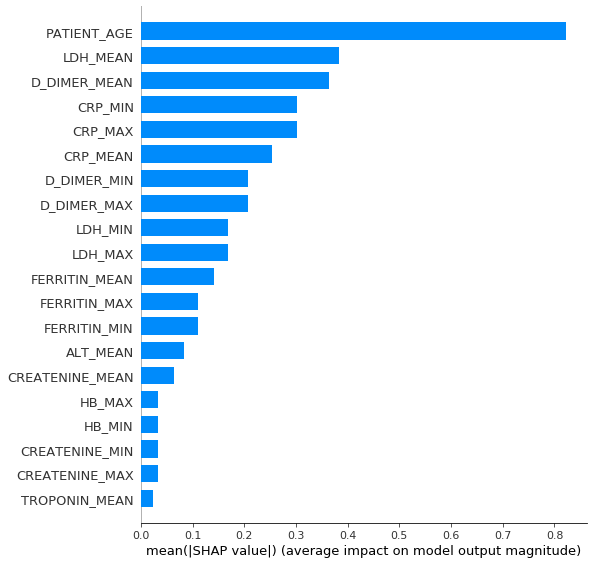

In [37]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.LinearExplainer(clf,X)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar",class_names=class_names)

In [38]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier().fit(X, Y)

In [39]:
feature_importance_dic=dict(zip(X_cols,clf.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(clf, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

PATIENT_AGE : 0.2522334883452821
CRP_MAX : 0.030307915736417605
CRP_MIN : 0.028885132592405677
NEURAL_D : 0.025495171095363266
ETHNIC_GROUP_A : 0.024757036305053784
SMOKING_HISTORY_NR|NR : 0.02392578288908956
HYPERTENSION : 0.02302128400529638
CARDIAC_D : 0.020135502777274664
OBESITY : 0.019145845340039384
DIABETES : 0.016048035617299002
NEUTROPHILS_MAX : 0.01586456084762383
RENAL_D : 0.015347555853663746
GENDER_2 : 0.01528691953284455
ETHNIC_GROUP_L : 0.01491516581160643
MAGLINANT_NEO : 0.014270073897044648
COPD : 0.01379492083101943
ETHNIC_GROUP_X : 0.013338544311669625
GLUCOSE_MAX : 0.013079141063786902
SODIUM_MEAN : 0.013026177653110729
GENDER_1 : 0.012879931971544321


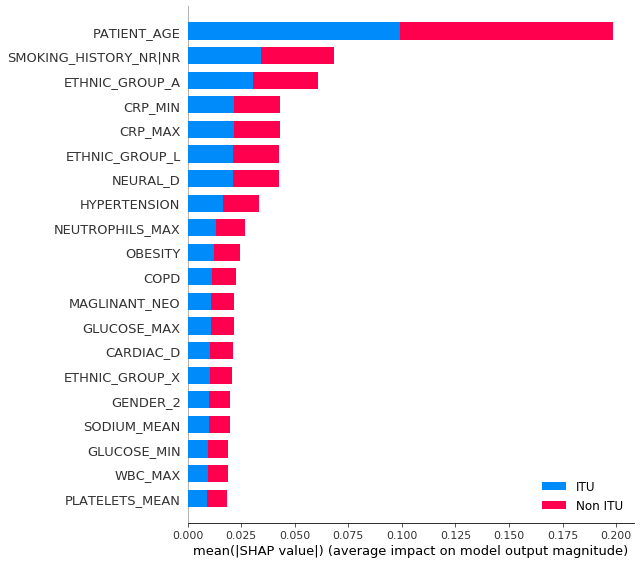

In [40]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar",class_names=class_names)

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100).fit(X, Y)

In [42]:
feature_importance_dic=dict(zip(X_cols,clf.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(clf, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

PATIENT_AGE : 0.4281463581827934
CRP_MIN : 0.10024209144244213
CRP_MAX : 0.04872248567480025
SMOKING_HISTORY_NR|NR : 0.03377159966295708
ETHNIC_GROUP_X : 0.027179326923327536
GLUCOSE_MAX : 0.024679492308392538
ETHNIC_GROUP_L : 0.022460203848822403
CREATENINE_MIN : 0.02163974254644666
SODIUM_MEAN : 0.01699731309405665
ETHNIC_GROUP_N : 0.01647262096604166
NEURAL_D : 0.01595668332430775
CREATENINE_MAX : 0.012372985116778111
META_SOLID_TUMOUR : 0.012311633260402093
NEUTROPHILS_MIN : 0.011917635814818573
GLUCOSE_MIN : 0.009922642732774314
TROPONIN_MEAN : 0.009736287296094768


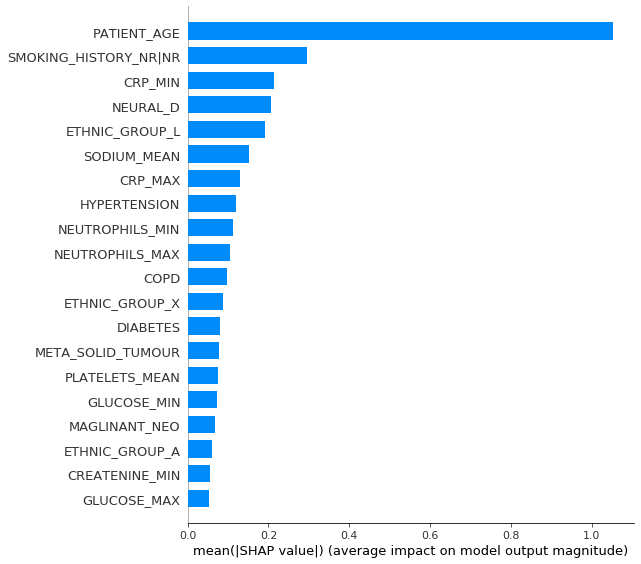

In [43]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar", class_names=class_names)

In [44]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=100).fit(X, Y)

In [45]:
feature_importance_dic=dict(zip(X_cols,clf.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(clf, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

CRP_MIN : 0.08374383
D_DIMER_MEAN : 0.0701999
CREATENINE_MIN : 0.052080188
LDH_MIN : 0.04581803
TRIGYCERIN_MEAN : 0.04523404
D_DIMER_MIN : 0.037901603
CREATENINE_MEAN : 0.036194187
ALT_MIN : 0.031977814
NEUTROPHILS_MIN : 0.031311434
TROPONIN_MIN : 0.025647746
META_SOLID_TUMOUR : 0.022650445
LYMPHOCYTES_MEAN : 0.022554293
SODIUM_MEAN : 0.021190414
POTASSIUM_MIN : 0.01959907
HB_MEAN : 0.019478096
UREA_MEAN : 0.018242227
UREA_MIN : 0.01812195
ETHNIC_GROUP_X : 0.01729391
PATIENT_AGE : 0.017127594
AST_MIN : 0.016457384
